/# **Emissions Metrics Analysis**
## **1. Introduction**

### **1.1 Project Overview**

- **Objective**: To design and implement a data mart for analyzing emissions metrics. This involves creating schemas, dimension tables, and a fact table to enable efficient querying and reporting.

- **Scope**: The project uses a dimensional model to facilitate emissions analysis across entities, commodities, and time.



### **1.2 Business Requirements**

- **Key Metrics**: Include production values, emissions by type (e.g., flaring, venting, fugitive methane), and total emissions.


- **Stakeholders**: Environmental analysts, policy makers, and reporting teams require actionable insights from the data.



### **1.3 Data Source** : [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/carbon-majors-emissions-data)



### **1.4 Brief Overview of Data**:

The Carbon Majors database tracks historical production data from 122 major oil, gas, coal, and cement producers, including investor-owned companies, state-owned entities, and nation-states. Spanning back to 1854, it covers over 1.42 trillion tonnes of CO2e, representing 72% of global fossil fuel and cement emissions since 1751. The dataset provides emissions data at varying levels of granularity, with key columns such as year, /,entity, entity type, commodity, production, and total emissions.  


### **1.5 List of points/questions being addressed with the data mart:**

  - What are the entities and their relationships in the emissions data? The dim.Entitities table consolidates data on parent entities, their types,and associated reporting entities. This helps establish relationships and hierarchies in emissions reporting.

  -  What commodities are involved in emissions reporting, and what are their production units? The dim.Commodity table organizes distinct commodities and their production units to support accurate tracking and aggregation of emissions data by type of commodity

  - What time periods are associated with emissions data?  The dim.Calendar table establishes a time dimension, with unique identifiers for each year, allowing temporal analysis of emissions metrics.

   - How do emissions metrics relate to entities, commodities, and time? The f.EmissionMetrics fact table aggregates and connects data from dim.Entities, dim.Commodity, and dim.Calendar to enable detailed analysis of production values and emissions across entities, commodities, and years.

  - What are the specific emission components contributing to total emissions? The fact table captures detailed metrics such as FlaringEmissions_MtCO2, VentingEmissions_MtCO2, and other operational emissions, enabling analysis of individual contributions to total emissions.




## **2. Schema and Table Creation**

### **2.1 Schema Creation**

- **Why Create Schemas**:

- For logical separation of tables based on their purpose (e.g., staging, dimensions, facts).
  - Easier management and enhanced security.

  
- **Schemas**:

```sql
/*********************************************************/
/******************    Schema DDL      *******************/
/*********************************************************/

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'dim' ) 
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA dim AUTHORIZATION dbo;'
END;

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'stg' ) 
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA stg AUTHORIZATION dbo;'
END;

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'f' ) 
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA f AUTHORIZATION dbo;'
END;

GO
```
### **Explanation:**
 This script checks if the schemas dim, stg, and f exist in the database. If any of these schemas do not exist, it creates them using the CREATE SCHEMA statement, with dbo (database owner) as the schema's authorization. The purpose is to ensure that these schemas are present before they are used in the database.

- dim: Stores dimension tables that hold descriptive information.
- stg: Temporary storage for raw or intermediate data from source systems.
- f:  Contains the fact table for transactional data and metrics.



**2.2 Dimension Table Creation**
Dimension tables are the foundation of the star schema. They store descriptive, categorical data used for filtering and grouping in analyses.


**Entities Dimension:**
•	**Purpose:** Stores hierarchical entity relationships such as parent organizations and reporting entities.




```sql
/*********************************************************/
/****************** Entities DIM Table  ******************/
/*********************************************************/

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Entities')
BEGIN
    CREATE TABLE dim.Entities (
        pkEntityID INT IDENTITY(1,1) NOT NULL,
        ParentEntity NVARCHAR(100) NOT NULL,
        ParentType NVARCHAR(50) NOT NULL,
        ReportingEntity NVARCHAR(100) NOT NULL
    );


    ALTER TABLE dim.Entities
    ADD CONSTRAINT PK_Entities PRIMARY KEY (pkEntityID);

    ALTER TABLE dim.Entities
    ADD CONSTRAINT UC_Entities UNIQUE (ParentEntity, ReportingEntity);
END;

```
### **Explanation:**
This script checks if the dim.Entities table exists, and if not, it creates it. The table has four columns, including a unique identifier (pkEntityID) that automatically generates values and ensures each row is unique. It also enforces a rule that no two rows can have the same combination of ParentEntity and ReportingEntity.

**•	Structure:**

o	pkEntityID: Primary key for unique identification.

o	ParentEntity and ReportingEntity: Text fields describing entities.

o	Unique constraint ensures no duplicate records for the same entity pair.



**Commodity Dimension**

•	Purpose: Captures details about commodities and their production units.

```sql
/*********************************************************/
/****************** Commodity DIM Table ******************/
/*********************************************************/

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Commodity')
BEGIN
    CREATE TABLE dim.Commodity (
        pkCommodityID INT IDENTITY(1,1) NOT NULL,
        Commodity NVARCHAR(50) NOT NULL,
        ProductionUnit NVARCHAR(50) NOT NULL
    );

    ALTER TABLE dim.Commodity
    ADD CONSTRAINT PK_Commodity PRIMARY KEY (pkCommodityID);

    ALTER TABLE dim.Commodity
    ADD CONSTRAINT UC_Commodity UNIQUE (Commodity, ProductionUnit);
END;

```
### **Explanation:**
This script checks if the dim.Commodity table exists, and if it doesn’t, it creates it. The table includes a unique identifier (pkCommodityID) that automatically generates values, along with Commodity and ProductionUnit columns. It ensures that the combination of Commodity and ProductionUnit is unique and defines pkCommodityID as the primary key to uniquely identify each row.

**•	Structure:**

o	pkCommodityID: Primary key.

o	Commodity and ProductionUnit: Text fields describing commodities and units.

**•	Constraints:**

o	Unique constraint ensures no duplicate commodities.




**Calendar Dimension**
•	Purpose: Tracks time-related data such as years for aggregation and trend analysis.

```sql
/*********************************************************/
/****************** Calendar DIM Table ******************/
/*********************************************************/

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Calendar')
BEGIN
    CREATE TABLE dim.Calendar (
        pkCalendarID INT NOT NULL,
        Year INT NOT NULL
    );


    ALTER TABLE dim.Calendar
    ADD CONSTRAINT PK_Calendar PRIMARY KEY (pkCalendarID);

    ALTER TABLE dim.Calendar
    ADD CONSTRAINT UC_Calendar UNIQUE (Year);
END;

```
### **Explanation:**
This script checks if the dim.Calendar table exists, and if it doesn’t, it creates it. The table includes a unique identifier (pkCalendarID) and a Year column, both of which are required. It ensures that pkCalendarID is the primary key and enforces a rule that each year must be unique in the table.

**•	Structure:**

o	pkCalendarID: Unique identifier for dates.

o	Year: Year of the record for grouping by time.




**2.3 Fact Table Creation**

The fact table stores measurable, quantitative data linked to dimensions.

**EmissionMetrics Fact Table**

•	Purpose: Stores detailed emissions data and production metrics.
```sql
/*********************************************************/
/****************** EmissionMetrics FACT Table ***********/
/*********************************************************/

IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'f' AND TABLE_NAME = 'EmissionMetrics')
BEGIN
    CREATE TABLE f.EmissionMetrics (
    pkEmissionID INT IDENTITY(1,1) NOT NULL,
    fkEntityID INT NOT NULL,
    fkCommodityID INT NOT NULL,
    fkCalendarID INT NOT NULL,
    ProductionValue FLOAT NOT NULL,
    ProductEmissions_MtCO2 FLOAT NOT NULL,
    FlaringEmissions_MtCO2 FLOAT NULL,
    VentingEmissions_MtCO2 FLOAT NULL,
    OwnFuelUseEmissions_MtCO2 FLOAT NULL,
    FugitiveMethaneEmissions_MtCO2e FLOAT NULL,
    TotalOperationalEmissions_MtCO2e FLOAT NULL,
    TotalEmissions_MtCO2e FLOAT NOT NULL	
);

-- Add Primary Key
ALTER TABLE f.EmissionMetrics
ADD CONSTRAINT PK_EmissionMetrics PRIMARY KEY (pkEmissionID);

-- Add Foreign Keys
ALTER TABLE f.EmissionMetrics
ADD CONSTRAINT FK_Emission_to_Entity
    FOREIGN KEY (fkEntityID) REFERENCES dim.Entities(pkEntityID);

ALTER TABLE f.EmissionMetrics
ADD CONSTRAINT FK_Emission_to_Commodity
    FOREIGN KEY (fkCommodityID) REFERENCES dim.Commodity(pkCommodityID);

ALTER TABLE f.EmissionMetrics
ADD CONSTRAINT FK_Emission_to_Calendar
    FOREIGN KEY (fkCalendarID) REFERENCES dim.Calendar(pkCalendarID);
END;

```
### **Explanation:**
This script checks if the f.EmissionMetrics table exists, and if it doesn’t, it creates it. The table stores emissions data, including details like production value, emissions from various sources, and total emissions, with a unique identifier (pkEmissionID) as the primary key. It establishes relationships by adding foreign key constraints linking fkEntityID, fkCommodityID, and fkCalendarID to the primary keys of the dim.Entities, dim.Commodity, and dim.Calendar tables, respectively.

**•	Structure:**

o	pkEmissionID: Primary key for unique identification.

o	fkEntityID, fkCommodityID, fkCalendarID: Foreign keys linking to dimension tables.

o	Metrics: Emissions and production values stored as numeric fields.

**•	Constraints:**

o	Primary key ensures uniqueness.

o	Foreign keys maintain data integrity across dimensions



**3. Data Loading**

**3.1 Dimension Table Loading**

The Dimension tables were populated with unique values extracted from staging data.


**Entities Dimension**

```sql
/*****************************************************************/
/******************  Load the Entities Dimension *****************/
/****************************************************************/
INSERT INTO dim.Entities (ParentEntity, ParentType, ReportingEntity)
SELECT DISTINCT ehg.parent_entity
	           ,ehg.parent_type
	           ,ehg.reporting_entity
FROM stg.emissions_high_granularity ehg
WHERE NOT EXISTS (
    SELECT 1 FROM dim.Entities e
    WHERE e.parententity = ehg.parent_entity
    AND e.reportingentity = ehg.reporting_entity
);

```
### **Explanation:**
This script inserts unique rows into the dim.Entities table by selecting distinct ParentEntity, ParentType, and ReportingEntity values from the stg.emissions_high_granularity table. Before inserting, it checks if a row with the same ParentEntity and ReportingEntity already exists in dim.Entities, ensuring no duplicates are added. This ensures the dim.Entities table contains only new, non-duplicate entries from the staging table.

**Steps used:**
1. Extracted distinct combinations of ParentEntity, ParentType, and ReportingEntity from staging.

2. Insert records only if they do not already exist in the dimension table



**Commodity Table Loading**

```sql
/*****************************************************************/
/****************** Load the Commodity Dimension*****************/
/****************************************************************/
INSERT INTO dim.Commodity (Commodity, ProductionUnit)
SELECT DISTINCT ehg.Commodity
               ,ehg.Production_Unit
FROM stg.emissions_high_granularity ehg
WHERE NOT EXISTS (
    SELECT 1 FROM dim.Commodity c
    WHERE c.Commodity = ehg.Commodity
    AND c.ProductionUnit = ehg.Production_Unit
);

```
### **Explanation:**
This script inserts unique rows into the dim.Commodity table by selecting distinct Commodity and ProductionUnit values from the stg.emissions_high_granularity table. It checks if a row with the same Commodity and ProductionUnit already exists in dim.Commodity to avoid duplicates. As a result, only new, non-duplicate commodities and production units are added to the table.

**Steps used:**
1. Extracted distinct combinations of Commodity and ProductionUnit from staging.

2. Insert records only if they do not already exist in the dimension table




Calendar Dimension

```sql
/*****************************************************************/
/******************Load the Calendar Dimension********************/
/****************************************************************/
IF (SELECT COUNT(*) FROM dim.Calendar) = 0
BEGIN
    -- Declare variables for date range
    DECLARE @StartDate DATE = '1854-01-01';
    DECLARE @EndDate DATE = DATEADD(YEAR, 10, GETDATE());
    DECLARE @CurrentDate DATE = @StartDate;

    -- Populate the Calendar table
    WHILE @CurrentDate <= @EndDate
    BEGIN
        INSERT INTO dim.Calendar (pkCalendarID, Year)
        VALUES (
            (YEAR(@CurrentDate) - 1854) * 10000 + DATEPART(DAYOFYEAR, @CurrentDate),
            YEAR(@CurrentDate)
        );

        SET @CurrentDate = DATEADD(DAY, 1, @CurrentDate);
    END
END;

```

### **Explanation:**
This script populates the dim.Calendar table if it is empty, starting from January 1, 1854, up to 10 years beyond the current date. It calculates a unique pkCalendarID for each day based on the year and day of the year and inserts the corresponding year. The script uses a loop to insert one row for each date in the specified range, incrementing the date by one day in each iteration.

**Steps used:**

1. Generate dates from 1854 to 10 years beyond the current year.


2. Create a unique identifier (pkCalendarID) using year and day of the year.




**3.2 Fact Table Loading**

**EmissionMetrics Fact Table Loading**

```sql
/*****************************************************************/
/**************Load the EmissionMetrics Fact Table***************/
/****************************************************************/
INSERT INTO f.EmissionMetrics (
     fkEntityID
    ,fkCommodityID
	,fkCalendarID
	,ProductionValue
	,ProductEmissions_MtCO2
	,FlaringEmissions_MtCO2
	,VentingEmissions_MtCO2
	,OwnFuelUseEmissions_MtCO2
	,FugitiveMethaneEmissions_MtCO2e
	,TotalOperationalEmissions_MtCO2e
	,TotalEmissions_MtCO2e
)
SELECT e.pkEntityID
      ,c.pkCommodityID
	  ,cal.pkCalendarID
	  ,ehg.Production_Value
	  ,ehg.Product_Emissions_MtCO2
	  ,ehg.Flaring_Emissions_MtCO2
      ,ehg.Venting_Emissions_MtCO2
	  ,ehg.Own_Fuel_Use_Emissions_MtCO2
      ,ehg.Fugitive_Methane_Emissions_MtCO2e
	  ,ehg.Total_Operational_Emissions_MtCO2e
	  ,ehg.Total_Emissions_MtCO2e
FROM stg.emissions_high_granularity ehg
     INNER JOIN dim.Entities e
     ON ehg.Parent_Entity = e.ParentEntity
     AND ehg.Reporting_Entity = e.ReportingEntity
     INNER JOIN dim.Commodity c
     ON ehg.Commodity = c.Commodity
     AND ehg.Production_Unit = c.ProductionUnit
     INNER JOIN dim.Calendar cal
     ON ehg.Year = cal.Year
;

```

### **Explanation:**

This script inserts data into the f.EmissionMetrics table by mapping values from the stg.emissions_high_granularity staging table to corresponding foreign keys and metrics. It joins the staging table with dim.Entities, dim.Commodity, and dim.Calendar tables to find matching foreign key values (fkEntityID, fkCommodityID, and fkCalendarID) based on entity, commodity, and year. The selected emissions and production values from the staging table are then inserted into f.EmissionMetrics`, creating detailed emission metrics records linked to the dimension tables.

**•	Steps used:**

1. Joined staging data with dimensions to resolve foreign keys.

2. Insert combined records into the fact table.



**4. Validation and Testing**

•	Data Validation: Verified dimension tables for completeness and uniqueness.

•	Reconciled fact table data with staging data for consistency.

•	Testing: Ensured queries and stored procedures produced accurate results


**5. Conclusion**

•	Successfully implemented a data mart for emissions analysis.

•	Ready for integration with visualization tools and reporting systems.



**Appendices**


**A. ER Diagram**

•	Visual representation of the schema and relationships.
[Emissions Metrics Analysis ERD](https://github.com/OkerekeChisom/SQL/blob/main/DW_ProjectERD.png)



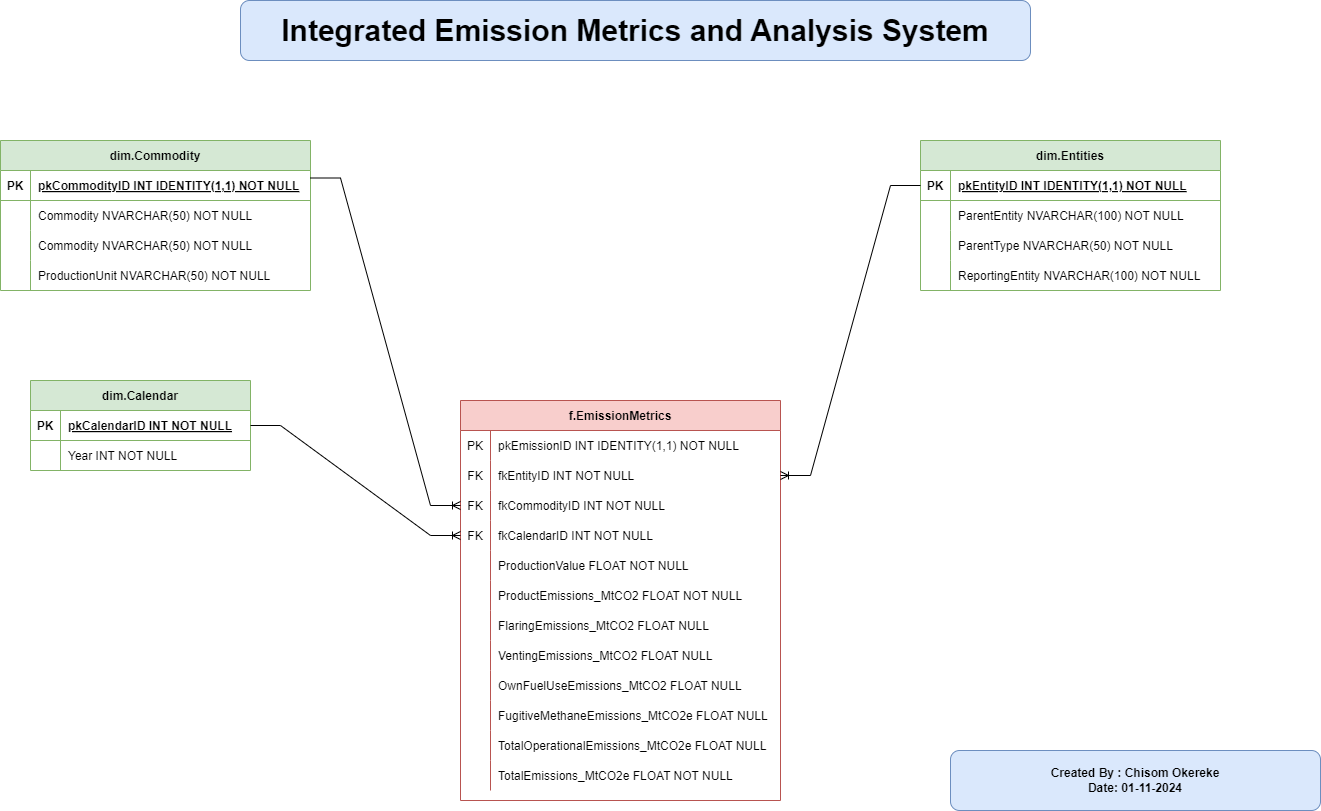








